# 2D Four-well potential

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from pydiffmap import diffusion_map as dm

%matplotlib inline

Load sampled data: discretized Langevin dynamics at temperature T=1, friction 1, and time step size dt=0.01

In [2]:
X=np.load('Data/4wells_traj.npy')

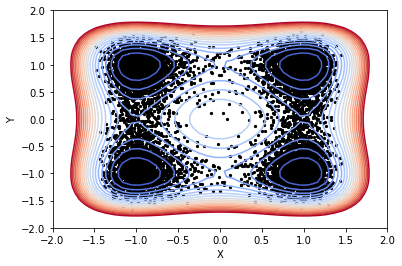

In [3]:
def DW1(x):
        return 2.0*(np.linalg.norm(x)**2-1.0)**2

def DW2(x):
        return 4.0*(np.linalg.norm(x)**2-1.0)**2

def DW(x):
    return DW1(x[0]) + DW1(x[1])

from matplotlib import cm

mx=5

xe=np.linspace(-mx, mx, 100)
ye=np.linspace(-mx, mx, 100)
energyContours=np.zeros((100, 100))
for i in range(0,len(xe)):
            for j in range(0,len(ye)):
                xtmp=np.array([xe[i], ye[j]] )
                energyContours[j,i]=DW(xtmp)

levels = np.arange(0, 10, 0.5)
plt.contour(xe, ye, energyContours, levels, cmap=cm.coolwarm)
plt.scatter(X[:,0], X[:,1], s=5, c='k')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()


 Compute diffusion map embedding

In [83]:
mydmap = dm.DiffusionMap(n_evecs = 2, epsilon = .2, alpha = 1.0, k=200)
dmap = mydmap.fit_transform(X)

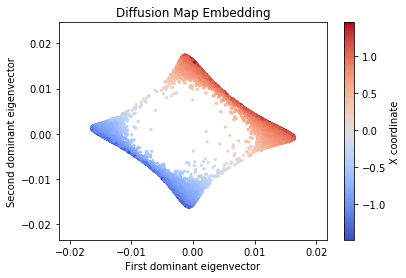

In [84]:
from matplotlib import cm
plt.scatter(dmap[:,0], dmap[:,1], c=X[:,0], s=5, cmap=cm.coolwarm)

clb=plt.colorbar()
clb.set_label('X coordinate')
plt.xlabel('First dominant eigenvector')
plt.ylabel('Second dominant eigenvector')
plt.title('Diffusion Map Embedding')

plt.show()

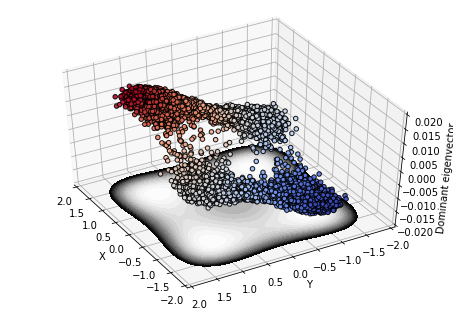

In [85]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

xx=np.meshgrid(X[:,0])
yy=np.meshgrid(X[:,1])

cset = ax.contourf(xe, ye, energyContours, levels=levels,offset=-0.02, cmap=cm.Greys)
ax.scatter(X[:,0], X[:,1], dmap[:,0], c= dmap[:,0], alpha=0.90, edgecolors='none', s=20, depthshade=True,  cmap=cm.coolwarm)
ax.view_init(elev=45., azim=150)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Dominant eigenvector')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_zlim([-0.02,0.02])

plt.show()

Compute Target Measure Diffusion Map for pi(q) = exp(-beta V(q)) with beta = 1 

In [226]:
V=DW
beta=1
target_distribution=np.zeros(len(X))
for i in range(len(X)):
    target_distribution[i]=np.exp(-beta*V(X[i]))
mytdmap = dm.TargetMeasureDiffusionMap(n_evecs = 2, epsilon = .01, alpha = 1.0, k=200)
tmdmap = mytdmap.fit_transform(X, target_distribution)

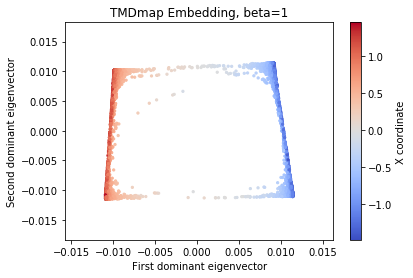

In [227]:
from matplotlib import cm
plt.scatter(tmdmap[:,0], tmdmap[:,1], c=X[:,0], s=5, cmap=cm.coolwarm)

clb=plt.colorbar()
clb.set_label('X coordinate')
plt.xlabel('First dominant eigenvector')
plt.ylabel('Second dominant eigenvector')
plt.title('TMDmap Embedding, beta=1')

plt.show()

Compute Target Measure Diffusion Map at low temperature, i.e. for pi(q) = exp(-beta V(q)) with beta = 10, from data obtained from sampling at higher temperature, i.e. pi(q) = exp(-beta V(q)) with beta = 1. 

In [228]:
V=DW
beta=10
target_distribution2=np.zeros(len(X))
for i in range(len(X)):
    target_distribution2[i]=np.exp(-beta*V(X[i]))
mytdmap2 = dm.TargetMeasureDiffusionMap( n_evecs = 2, epsilon = .1, alpha = 1.0, k=200)
tmdmap2 = mytdmap2.fit_transform(X,target_distribution2)

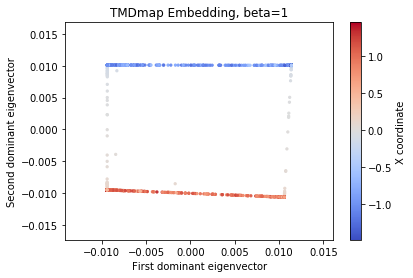

In [229]:
from matplotlib import cm
plt.scatter(tmdmap2[:,0], tmdmap2[:,1], c=X[:,0], s=5, cmap=cm.coolwarm)

clb=plt.colorbar()
clb.set_label('X coordinate')
plt.xlabel('First dominant eigenvector')
plt.ylabel('Second dominant eigenvector')
plt.title('TMDmap Embedding, beta=1')

plt.show()

Let's look at the KDE

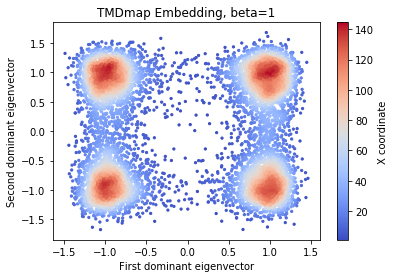

In [230]:
plt.scatter(X[:,0], X[:,1], c = mytdmap.q, s=5, cmap=cm.coolwarm)

clb=plt.colorbar()
clb.set_label('X coordinate')
plt.xlabel('First dominant eigenvector')
plt.ylabel('Second dominant eigenvector')
plt.title('TMDmap Embedding, beta=1')

plt.show()

Now we check how well we can approximate the target distribution by the formula in the paper (left dominant eigenvector times KDE).

In [231]:
import scipy.sparse.linalg as spsl
P = mytdmap.P
[evals, evecs] = spsl.eigs(P.transpose(),k=1, which='LM')

phi = np.real(evecs.ravel())

In [232]:
q_est = phi*mytdmap.q
q_est = q_est/sum(q_est)
q_exact = target_distribution/sum(target_distribution)
print(np.linalg.norm(q_est - q_exact,1))

0.0265648080023


visualize both. there is no visible difference.

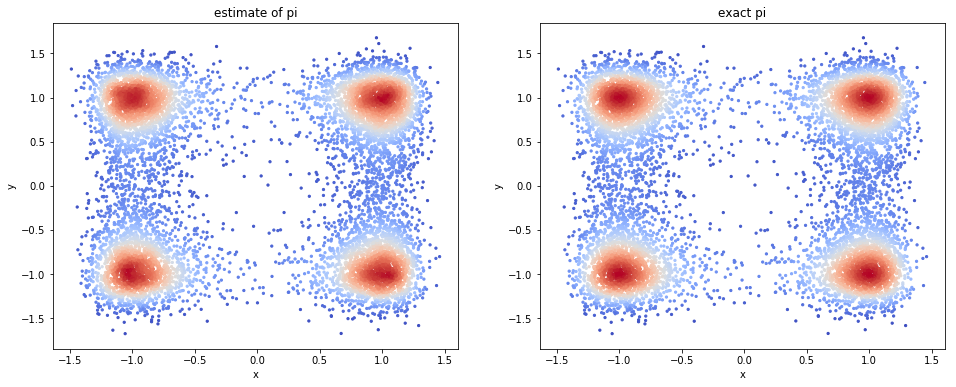

In [233]:
plt.figure(figsize=(16,6))

ax = plt.subplot(121)
ax.scatter(X[:,0], X[:,1], c = q_est, s=5, cmap=cm.coolwarm)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('estimate of pi')

ax2 = plt.subplot(122)
ax2.scatter(X[:,0], X[:,1], c = q_exact, s=5, cmap=cm.coolwarm)

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('exact pi')

plt.show()

we check some observable avarages.

In [234]:
Energy=np.zeros(len(X))
for i in range(len(X)):
    Energy[i]=V(X[i])

In [235]:
raw = np.mean(Energy)
print(raw)

0.84388226425


In [236]:
phi = phi/sum(phi)
reweight1 = np.sum(Energy*phi)
print(reweight1)

0.851111264826


In [237]:
weights = target_distribution/mytdmap.q
weights = weights/sum(weights)

In [238]:
reweight2 = np.sum(Energy*weights)
print(reweight2)

0.880361110969
